In [84]:
import numpy as np
from matplotlib import pyplot as plt
from enum import IntEnum
from itertools import islice
from IPython.display import clear_output

In [85]:
class var(IntEnum):
    freq, mag_db, ph_deg = range(3)

In [86]:
# Data interpolation Enable.
iterpEnable = True
N_points = 10000
Ri = 20

In [87]:
file_list = ['uncoated', 'coated']
N = len(file_list)
import_data = np.empty(N, dtype=object)
for n, file_name in enumerate(file_list):
    import_data[n] = np.loadtxt('AP300/' + file_name + '.dat', skiprows=1)
    # Data descaling.
    import_data[n][:,var.mag_db.value] += 20*np.log10(Ri)
    import_data[n][:,var.ph_deg.value] = np.unwrap(import_data[n][:,var.ph_deg.value]*np.pi/180 + np.pi)*180/np.pi

In [88]:
data = np.empty(N, dtype=object)
for n in range(N):
    if iterpEnable:
        data[n] = np.zeros((N_points, len(var)))
        data[n][:,var.freq.value] = np.logspace(np.log10(min(import_data[n][:,var.freq.value])),
                                                np.log10(max(import_data[n][:,var.freq.value])),
                                                N_points)
        for k in islice(var, var.mag_db.value, None):
            data[n][:,k.value] = np.interp(data[n][:,var.freq.value],
                                            import_data[n][:,var.freq.value],
                                            import_data[n][:,k.value])
    else:
        data[n] = import_data[n].copy()

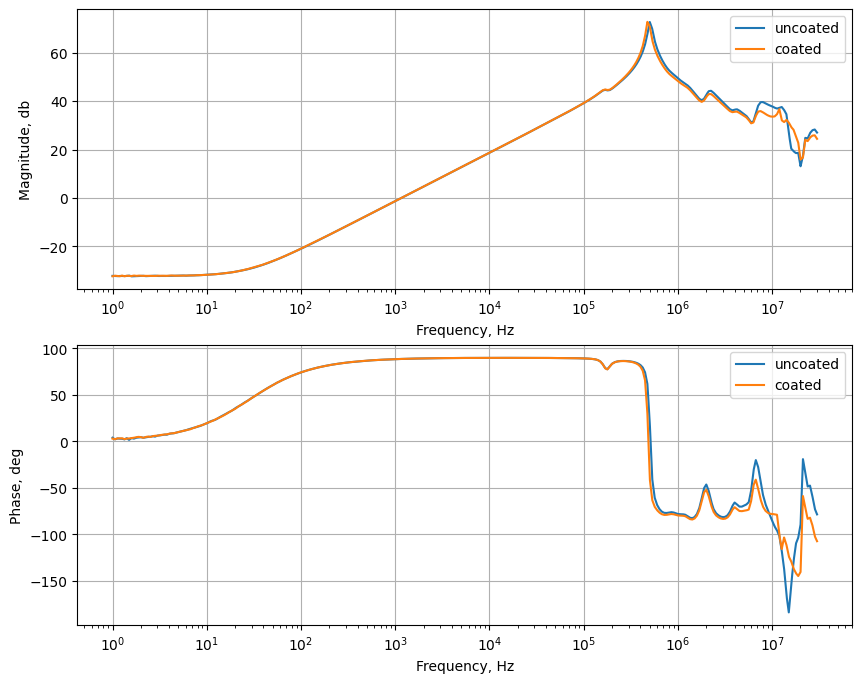

In [89]:
user_ylabel = ['Magnitude, db', 'Phase, deg']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx in range(2):
    ax = axes[idx]
    for n in range(N):
        ax.plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_list[n])
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)

#plt.savefig('readme_img/energy_pywt.png', bbox_inches='tight')
plt.show()

In [90]:
# Parameters.
L_b = 136e-6
r_b = 0.025
#C_b = 725e-12
C_b = 1.0
R_b = 6e3

In [91]:
def reactor_model(freq, L, r, C):
    s = 1j * 2 * np.pi * freq
    L *= L_b
    r *= r_b
    C *= C_b
    # Complex gain.
    #gain_comp = (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) * R) / (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) + R)
    #gain_comp = 1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L))
    #gain_comp = (r + s*L) / (1 + (s*C)*(r + s*L))
    gain_comp = (r + s*L) * C
    #gain_comp = R /(s*C) / (R + 1/(s*C)) * (r + s*L) / (R /(s*C) / (R + 1/(s*C)) + (r + s*L))
    
    # Magnitude.
    gain_abs = 20*np.log10(np.abs(gain_comp))
    #gain_abs = np.abs(gain_comp)
    gain_phase = np.unwrap(np.angle(gain_comp))*180/np.pi

    return [gain_abs, gain_phase]

In [92]:
N_DATA = 0
user_fontsize = 14

L_sel = 1.0
r_sel = 1.0
C_sel = 1.0

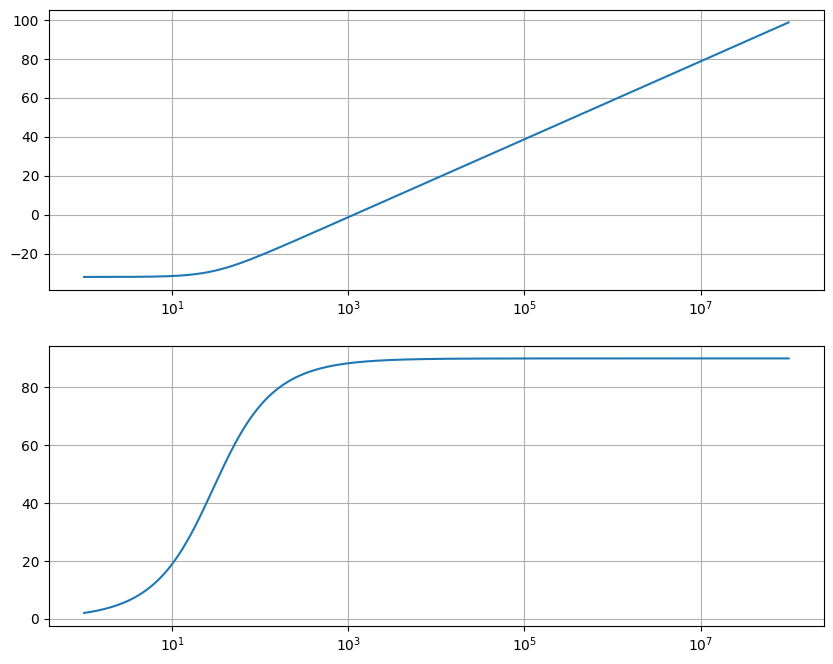

In [93]:
# Create frequency array.
N = int(1e3)
f_min = 1
f_max = 100e6
freq = np.logspace(np.log10(f_min), np.log10(f_max), N)

abs_phase_dataset = reactor_model(freq, L_sel, r_sel, C_sel)#, R)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx in range(2):
    axs[idx].plot(freq, abs_phase_dataset[idx])
    axs[idx].axes.grid(True)
    axs[idx].set_xscale('log')
plt.show()

Амплитудная характеристика принята в качестве отклика.

In [94]:
# freq - частоты.
# y - эталон отклика.
def loss_func(freq, y, w):

    [abs_dataset, _] = reactor_model(freq, L=w[0], r=w[1], C=w[2])#, R)
    #[_, phase_dataset] = reactor_model(freq, L=w[0], r=w[1], C=w[2])#, R)

    # Функция возвращает сумму квадратов отклонений наблюдений от эталона.
    return np.sum((y - abs_dataset)**2)

In [95]:
loss_func(freq=data[N_DATA][:7000, var.freq.value], y=data[N_DATA][:7000, var.mag_db.value], w=[1.0]*3)


501.46445657304866

In [96]:
len(data[N_DATA])

10000

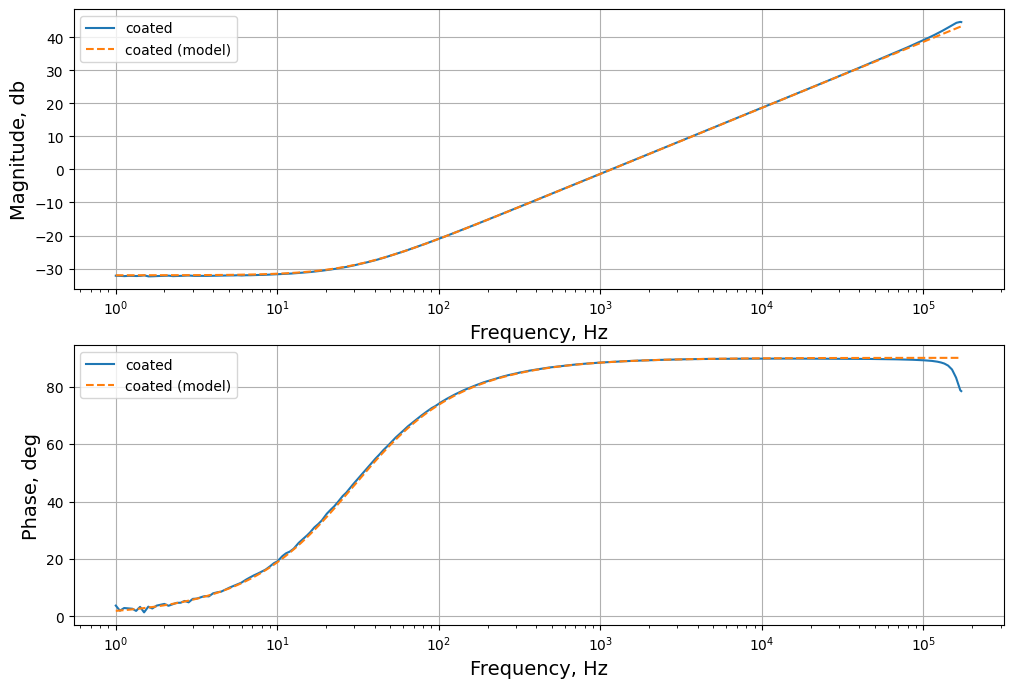

In [97]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
abs_phase_dataset = reactor_model(data[N_DATA][:7000, var.freq.value], L_sel, r_sel, C_sel)

for idx, ax in enumerate(axs):
    ax.plot(data[N_DATA][:7000, var.freq.value], data[N_DATA][:7000, idx + 1], label=file_name)
    ax.plot(data[N_DATA][:7000, var.freq.value], abs_phase_dataset[idx], '--', label=file_name + ' (model)')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    ax.set_xscale('log')
    ax.legend()
plt.show()

In [98]:
def model_fit(X_train, y_train, lr_multiplier, lr_coeff, tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff_1 = np.array([0.9, 1.1, 1.2])
    # Принимаем шаг в 1% относительно начального приближения и вводим соответствующие приращения.
    w_step = 0.01 * w_coeff_1
    w_coeff = w_coeff_1 - w_step
    w_coeff_2 = w_coeff_1 + w_step
    
    # Массивы для каждой переменной отдельно.
    x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
    x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
    x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]

    # Конвертируем в сетку.
    X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
    
    # Формируем массив значений функции потерь, для вычисления градиента.
    # Initialize array to store loss values.
    loss_func_grad = np.zeros_like(X1)
    # Compute loss at each point in the grid.
    # Note: This loop can be slow for large grids. Vectorization is better if possible.
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            for k in range(X1.shape[2]):
                w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                loss_func_grad[i,j,k] = loss_func(
                    freq=X_train,
                    y=y_train,
                    w=w_local)
    print(loss_func_grad)
    # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
    grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
    grad = np.zeros((len(grad_grid),))
    # Выбираем значение в самом центре окрестности.
    for idx, grad_axis in enumerate(grad_grid):
        grad[idx] = grad_axis[1][1,1]
    
    print(grad)
    
    grad_norm = np.linalg.norm(grad, ord=None, axis=None)
    
    loss = loss_func(
                    freq=X_train,
                    y=y_train,
                    w=w_coeff_1)
    loss_arr = [loss]
    
    for i in range(iteration_max):
        '''
        if i==0:
            learning_rate = np.array([1.0]*len(grad))*0.00001
        else:
            learning_rate = np.array([1.0]*len(grad))*lr_multiplier

        lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1+learning_rate*grad))) < lr_coeff * lr_norm * grad_norm**2:
            learning_rate *= lr_multiplier
            lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)

        print('center',loss_func(freq=X_train, y=y_train, w=w_coeff_1))
                print('higher', loss_func(freq=X_train, y=y_train, w=(w_coeff_1+learning_rate*grad)))
                print('lower', loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad)))
                break
                
        
        learning_rate = np.array([1.0]*len(grad))*lr_multiplier**20
        for k in range(len(learning_rate)):
            lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
            while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * lr_norm * grad_norm**2:
                print((loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))))
                learning_rate[k] *= lr_multiplier
                
                lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
        '''
        learning_rate = lr_multiplier
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * learning_rate * grad_norm**2:
            print((loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))))
            learning_rate *= lr_multiplier
        
        
        # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
        w_step = - learning_rate * grad
        print('w_step:', w_step)
        w_coeff = w_coeff_1.copy()
        w_coeff_1 += w_step
        w_coeff_2 = w_coeff + 2*w_step

        # Массивы для каждой переменной отдельно.
        x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
        x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
        x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]
        
        # Конвертируем в сетку.
        X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
        
        # Формируем массив значений функции потерь, для вычисления градиента.
        # Initialize array to store loss values.
        loss_func_grad = np.zeros_like(X1)
        # Compute loss at each point in the grid.
        # Note: This loop can be slow for large grids. Vectorization is better if possible.
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                for k in range(X1.shape[2]):
                    w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                    loss_func_grad[i,j,k] = loss_func(
                        freq=X_train,
                        y=y_train,
                        w=w_local)
        
        # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
        grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
        grad = np.zeros((len(grad_grid),))        
        # Выбираем значение в самом центре окрестности.
        for idx, grad_axis in enumerate(grad_grid):
            grad[idx] = grad_axis[1][1,1]
        grad_norm = np.linalg.norm(grad, ord=None, axis=None)
        print('grad:', grad)
        print('grad_norm:', grad_norm)
        print('parameters:', w_coeff_1)
        
        loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
        
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        loss_arr.append(loss)

        if grad_norm < tolerance:
            break
    
    return w_coeff_1, loss_arr

In [107]:
weights, losses = model_fit(
    X_train = data[N_DATA][:, var.freq.value],
    y_train = data[N_DATA][:, var.mag_db.value],
    lr_multiplier=0.5,
    lr_coeff = 0.5,
    tolerance=1e-2)

[[[3434019.44482744 3447840.68440725 3461674.54184235]
  [3434808.40993253 3448661.36549315 3462526.62332192]
  [3435617.87256515 3449502.31609146 3463398.74856763]]

 [[3447048.74239458 3460990.76709626 3474944.20779129]
  [3447840.68440725 3461814.33619667 3475799.08927684]
  [3448653.05740351 3462658.10914874 3476673.94974214]]

 [[3460064.4986513  3474126.1941822  3488198.11493218]
  [3460859.33758648 3474952.57219797 3489055.71820165]
  [3461674.54184235 3475799.08927684 3489933.23652795]]]
[1460622.59471251   75788.27511246 1164933.53623274]
-560556975.3394214
-504998729.99456954
-452340159.2133328
-402581145.5081427
-355721471.7168627
-311760739.1385521
-270698221.60908616
-232532609.2474506
-197261567.1046413
-164880994.72503588
-135383830.02328655
-108758229.69739749
-84985100.98499052
-64035694.13387972
-45873226.943723604
-30478093.675997593
-17887824.322286986
-7989109.199514148
-944755.4899673564
-2774517.814527872
268136.3672389379
w_step: [-0.34823956 -0.01806933 -0.2777

KeyboardInterrupt: 

In [100]:
def grad_func(freq, y, w):
    L_grad = w[0]
    r_grad = w[1]
    C_grad = w[2]
    [abs_dataset, _] = reactor_model(freq, L=L_grad, r=r_grad, C=C_grad)#, R)
    np.sum(2*( abs_dataset - y)* )
    return 

SyntaxError: invalid syntax (814325224.py, line 6)

<function matplotlib.pyplot.show(close=None, block=None)>

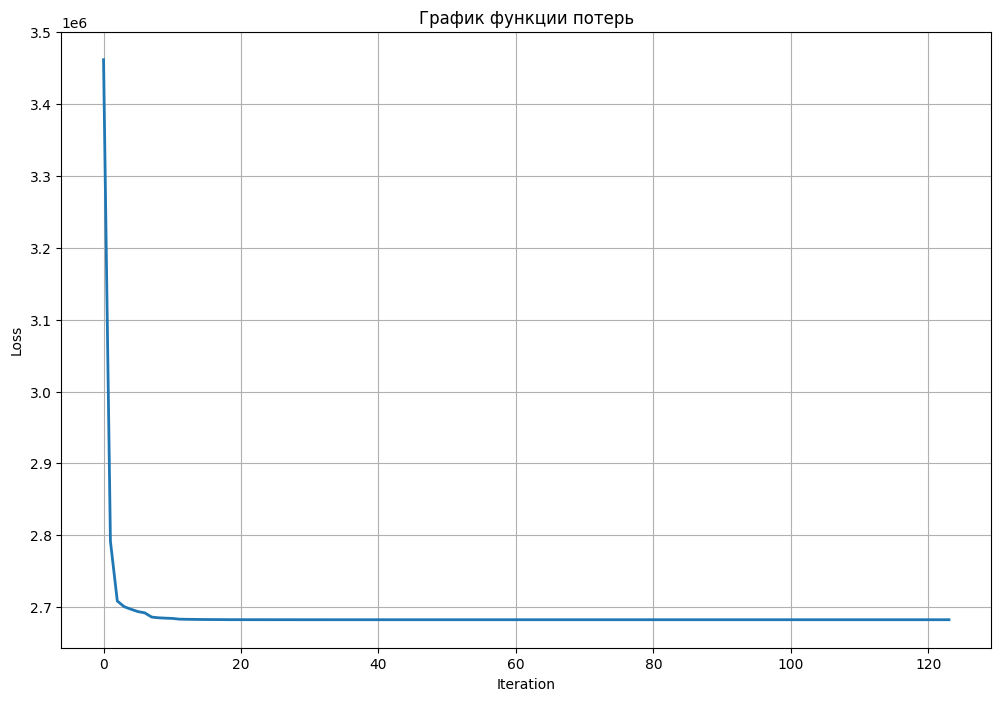

In [101]:
plt.figure(figsize=(12, 8))
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.grid()
plt.show

In [104]:
print('Оптимальные значения коэффициентов:')
print('L=' + str(np.round(weights[0]*L_b, 8)))
print('r=' + str(np.round(weights[1]*r_b, 3)))
print('C=' + str(np.round(weights[2]*C_b, 10)))

Оптимальные значения коэффициентов:
L=4.272e-05
r=0.032
C=1.0150692805


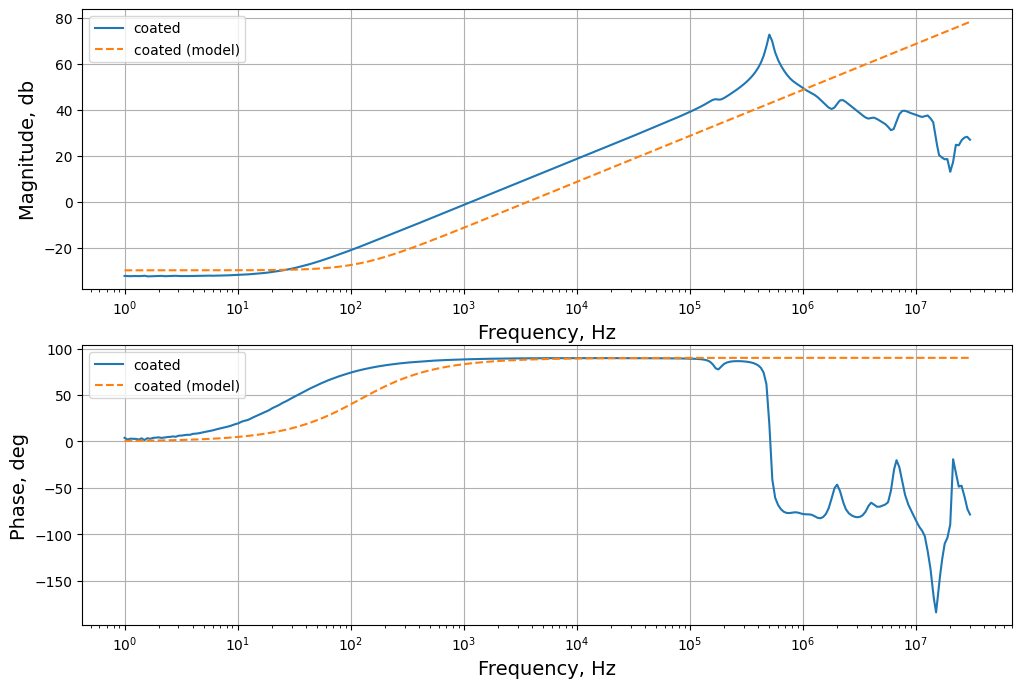

In [105]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
abs_phase_dataset = reactor_model(data[N_DATA][:, var.freq.value], L=weights[0], r=weights[1], C=weights[2])

for idx, ax in enumerate(axs):
    ax.plot(data[N_DATA][:, var.freq.value], data[N_DATA][:, idx + 1], label=file_name)
    ax.plot(data[N_DATA][:, var.freq.value], abs_phase_dataset[idx], '--', label=file_name + ' (model)')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    ax.set_xscale('log')
    ax.legend()
plt.show()